This feature selection notebook does a filter followed by a wrapper for a binary dependent variable (binary classification). It's capable of doing the filter on more than one file. The variable files are called vars1.csv, vars2.csv ... Or you can make the input file name(s) anything you want. The filter runs separately on each vars file and keeps the top num_filter variables from each file. If there are more than one vars files we'll again select the top num_filter variables across all the vars.csv files.

Things to modify if you use this notebook:

To keep things simple arrange your data so that the rare class has the label 1 and the 
common class has the label 0. You can do the reverse if you want but then you need to modify more things in this code.

The most important parameters are in cell 2 and 20. The main ones you should try experimenting with are num_out_of_filter and num_out_of_wrapper. In cell 2 you should set the name of the record identifying number (it's good to use a record number to keep track of things) and the name of the binary dependent variable. This particular version is set for a fraud problem.

Make sure your validation/out-of-time population and any other record exclusion is set correctly and as you want for your problem in cell 3. This define the records in the data file that you for whatever reason you don't want to include in your feature selection process.

Cell 20 has the SequentialFeatureSelector (SFS) settings. You can try different wrapper models with different amounts of commplexity. You can select either forward or backward. The filter is pretty fast. The wrapper is what takes the most time. I find forward selection runs much faster than backward.

There's a parameter njobs that controls the # threads used in the wrapper. Set it to 1 for a single thread and it should work fine, but you might be able to succeed with njobs = -1, which lets the machine set the maximum # threads based on the CPU. With this setting the kernel may die because of memory. The njobs = -1 doesn't take into consideration the memory requirements.

Recommendations: Try a few simple runs just to make sure all's working. Start with num_out_of_filter = 20, num_out_of_wrapper = 5, increase from there. I like num_out_of_filter as high as around 10% to 20% of the # candidate variables, but not much higher than a few hundred. You don't need num_out_of_wrapper large if you're doing forward selection. Most problems will saturate before 20. You can try a few different simple wrapper models like RF (5 trees, 10 layers), catboost (10 trees, 3 layers), LGBM (same). They're pretty fast. You can try forward and backward. I'd start with forward. In the end, select one of these as your favorite run and go with those variables. Don't mix variables across different runs.

If balance = 0 the entire files are used. If balance != 0 then balance is the RATIO OF BADS TO GOODS retained for the rest of the feature selection. We keep all the rare class (bads) and downsample the goods. I think in general it's better to keep balance = 0.

In [41]:
!pip install mlxtend



In [42]:

!pip install catboost 

In [43]:
!pip install lightgbm

In [44]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
%matplotlib inline
start_time = dt.datetime.now()

In [45]:
# set some parameters
num_files = 1 # this is the number of files for the candidate variables, usually just 1.
# num_out_of_filter is the number of variables that we'll keep from the filter. The more the better, but the wrapper will run slower.
# num_out_of_wrapper is the number we'll keep from the wrapper. These will then be our final variables for the models.
# I recommend set num_out_of_filter to be about 10 to 20% of the original # variables.
num_out_of_filter = 200
# I recommend set num_out_of_wrapper to be about 40, then look for a saturation of the model performance as variables are added.
# Then you can run it again with num_out_of_wrapper just a bit above this saturation point, not more than about twice this saturation number.
num_out_of_wrapper = 20
balance = 0
detect_rate = .03
index_name = 'Recnum'
y_name = 'Fraud'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [46]:
# %%time
# filter_score_df_list = []
# for i in range(num_files):
# #     file_name = "vars"+str(i+1)+'.csv'
#     file_name = 'candidate_variables.csv'
#     df = pd.read_csv(file_name)
#     print("********** working on",file_name,"size is",df.shape)
#     df = df.set_index(index_name) 
#     df = df[df.index <= 85730] # remove the last two months as the out-of-time data (OOT)
#     df = df[df.index >= 3515] # remove the first 2 weeks of records since their variables aren't well formed
#     df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
#     goods = df[df[y_name] == good_label]
#     bads = df[df[y_name] == bad_label]
#     del df # don't need this file anymore
#     num_goods = len(goods)
#     num_bads = len(bads)
#     num_vars = len(bads.columns)-2
#     if(balance != 0):
#         if(i == 0):
#             num_goods_desired = int(min(num_goods,num_bads*balance))
#             goods = goods.sample(n=num_goods_desired,random_state=1)
#             goods_keep = list(goods.index)
#             goods_keep.sort()
    
#         if(i > 0):
#             goods = goods.loc[goods_keep] 
            
#     df_sampled = pd.concat([goods,bads])
#     df_sampled.sort_index(inplace=True)
#     filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
#     filter_score.columns = ['variable','filter score']   
#     j = 0
#     for column in df_sampled:
#         filter_score.loc[j,'variable'] = column
#         filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
#         j = j+1
#         if j%100 == 0:
#             print(j)

#     filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
#     vars_keep = list(filter_score['variable'][1:num_out_of_filter+1]) 
#     print(file_name,filter_score.head(20))
#     if(i == 0): # if first time through need to initialize some stuff
#         Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
#         df_top = df_sampled.filter(vars_keep, axis=1)
            
#     if(i > 0): # if more than one variable file we use this loop
#         data_new_top = df_sampled.filter(vars_keep, axis=1)
#         df_top = pd.concat([df_top,data_new_top], axis=1)

#     filter_score_df_list.append(filter_score)
    
#     del goods # delete these before starting the next file, if any
#     del bads
#     gc.collect()
# filter_score = pd.concat(filter_score_df_list)

In [47]:
for i in range(num_files):
    file_name = 'candidate_variables.csv'
    print("********** working on", file_name)

    # --- CHUNKED LOADING ---
    chunk_size = 10000
    chunks = []

    for chunk in pd.read_csv(file_name, chunksize=chunk_size):
        chunk = chunk.set_index(index_name)
        chunk = chunk[(chunk.index >= 3515) & (chunk.index <= 85730)]
        chunks.append(chunk)

    df = pd.concat(chunks)
    print("✅ Loaded shape:", df.shape)

    df['RANDOM'] = np.random.ranf(len(df))  # Add random variable
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df  # clear memory

    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns) - 2  # exclude index + y column

    if balance != 0:
        if i == 0:
            num_goods_desired = int(min(num_goods, num_bads * balance))
            goods = goods.sample(n=num_goods_desired, random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
        else:
            goods = goods.loc[goods_keep]

    df_sampled = pd.concat([goods, bads]).sort_index()

    filter_score = pd.DataFrame(np.zeros((num_vars + 1, 2)))
    filter_score.columns = ['variable', 'filter score']

    j = 0
    for column in df_sampled:
        filter_score.loc[j, 'variable'] = column
        filter_score.loc[j, 'filter score'] = sps.ks_2samp(goods[column], bads[column])[0]
        j += 1
        if j % 100 == 0:
            print(f"Processed {j} variables")

    filter_score.sort_values(by='filter score', ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_out_of_filter + 1])
    print(file_name, filter_score.head(20))

    if i == 0:
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
    else:
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top, data_new_top], axis=1)

    filter_score_df_list.append(filter_score)
    del goods, bads
    gc.collect()

filter_score = pd.concat(filter_score_df_list)

********** working on candidate_variables.csv
✅ Loaded shape: (81893, 2650)
Processed 100 variables
Processed 200 variables
Processed 300 variables
Processed 400 variables
Processed 500 variables
Processed 600 variables
Processed 700 variables
Processed 800 variables
Processed 900 variables
Processed 1000 variables
Processed 1100 variables
Processed 1200 variables
Processed 1300 variables
Processed 1400 variables
Processed 1500 variables
Processed 1600 variables
Processed 1700 variables
Processed 1800 variables
Processed 1900 variables
Processed 2000 variables
Processed 2100 variables
Processed 2200 variables
Processed 2300 variables
Processed 2400 variables
Processed 2500 variables
Processed 2600 variables
candidate_variables.csv                                    variable  filter score
1                                     Fraud      1.000000
21                          Cardnum_total_1      0.591114
17                          Cardnum_count_1      0.576927
26                         

In [48]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score.reset_index(drop=True,inplace=True)

In [87]:
filter_score.head(20)

,filter score
variable,
Fraud,1.000000
Cardnum_total_1,0.591114
Cardnum_total_1,0.591114
Cardnum_count_1,0.576927
Cardnum_count_1,0.576927
Cardnum_count_3,0.572199
Cardnum_count_3,0.572199
Cardnum_total_3,0.569585
Cardnum_total_3,0.569585


In [50]:
filter_score.tail(10)

,variable,filter score
5292,Card_Merchdesc_Zip_unique_count_for_Merchdesc_...,0.000013
5293,Merchnum_desc_Zip_unique_count_for_Merchnum_de...,0.000013
5294,merch_zip_unique_count_for_merch_state_1,0.000000
5295,merch_zip_unique_count_for_merch_state_3,0.000000
5296,Merchant_dominance_score,0.000000
5297,merch_zip_unique_count_for_merch_state_3,0.000000
5298,merch_zip_unique_count_for_merch_state_1,0.000000
5299,Merchant_dominance_score,0.000000
5300,card_merch_unique_count_for_Cardnum_1,0.000000
5301,card_merch_unique_count_for_Cardnum_1,0.000000


In [51]:
filter_score.shape

(5302, 2)

In [52]:
filter_score.head(80).to_csv('filter_top.csv')
vars_keep = list(filter_score['variable'][num_files:num_out_of_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['Fraud', 'Cardnum_total_1', 'Cardnum_total_1', 'Cardnum_count_1', 'Cardnum_count_1', 'Cardnum_count_3', 'Cardnum_count_3', 'Cardnum_total_3', 'Cardnum_total_3', 'Cardnum_total_0', 'Cardnum_total_0', 'Cardnum_count_0', 'Cardnum_count_0', 'Cardnum_vdratio_1by60', 'Cardnum_vdratio_1by60', 'Cardnum_unique_count_for_card_state_1', 'Cardnum_unique_count_for_card_state_1', 'Cardnum_unique_count_for_card_zip_1', 'Cardnum_unique_count_for_card_zip_1', 'Cardnum_vdratio_1by30', 'Cardnum_vdratio_1by30', 'Cardnum_count_7', 'Cardnum_count_7', 'Cardnum_total_7', 'Cardnum_total_7', 'Cardnum_unique_count_for_Merchnum_1', 'Cardnum_unique_count_for_Merchnum_1', 'Card_dow_total_7', 'Card_dow_total_7', 'Card_dow_vdratio_0by60', 'Card_dow_vdratio_0by60', 'Cardnum_unique_count_for_card_state_3', 'Cardnum_unique_count_for_card_state_3', 'Card_dow_vdratio_0by30', 'Card_dow_vdratio_0by30', 'Cardnum_unique_count_for_card_zip_3', 'Cardnum_unique_count_for_card_zip_3', 'Cardnum_max_1', 'Cardnum_max_

In [53]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,Cardnum_total_1,Cardnum_count_1,Cardnum_count_3,Cardnum_total_3,Cardnum_total_0,Cardnum_count_0,Cardnum_vdratio_1by60,Cardnum_unique_count_for_card_state_1,Cardnum_unique_count_for_card_zip_1,Cardnum_vdratio_1by30,...,Cardnum_total_amount_1_by_14,card_state_total_amount_1_by_60,Cardnum_actual/max_3,card_zip_total_amount_1_by_60,Cardnum_variability_avg_0,card_state_count_1_by_60,card_state_count_1_by_60_sq,Card_dow_max_60,Card_dow_count_0_by_30,Card_dow_count_0_by_30_sq
Recnum,,,,,,,,,,,,,,,,,,,,,
3515,1551.02,3.0,7.0,1964.73,333.47,1.0,0.000641,3.0,3.0,0.001282,...,0.008548,0.002835,0.358412,0.002835,0.000,0.005556,0.000093,333.47,0.011111,0.000370
3516,660.87,2.0,34.0,834.91,4.37,1.0,0.000140,2.0,2.0,0.000280,...,0.039784,0.000137,0.006657,0.000137,0.000,0.000141,0.000002,15.40,0.001042,0.000035
3517,2904.08,7.0,14.0,8459.94,271.93,1.0,0.001768,4.0,5.0,0.003535,...,0.014012,0.003627,0.110004,0.004211,0.000,0.005000,0.000083,271.93,0.033333,0.001111
3518,664.49,3.0,35.0,838.53,7.99,2.0,0.000417,2.0,2.0,0.000833,...,0.039881,0.000250,0.005514,0.000250,0.375,0.000280,0.000005,15.40,0.002020,0.000067
3519,16.28,1.0,1.0,16.28,16.28,1.0,0.000011,1.0,1.0,0.000023,...,0.071429,0.016667,1.000000,0.016667,0.000,0.016667,0.000278,16.28,0.033333,0.001111


In [54]:
df_keep.shape

(81893, 101)

In [55]:
Y.head()

,Fraud
Recnum,
3515,0.0
3516,0.0
3517,0.0
3518,0.0
3519,0.0


In [56]:
Y = Y.values.ravel()
Y_save = Y.copy()

In [57]:
# Y = np.array(Y)
X = df_keep
print(Y)

[0. 0. 0. ... 0. 0. 0.]


In [58]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:00:51.878657


In [59]:
print(X.shape,Y.shape)

(81893, 101) (81893,)


In [60]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [61]:
# I'd like to define a scoring for the wrapper that's KS, but I haven't gotten around to this yet.
# def KSscore(classifier, x,y)

In [62]:
def fdr(classifier, x, y, cutoff=0.03):
    # Calculates FDR score for the given classifier on dataset x and y with cutoff value
    return fdr_prob(y, classifier.predict_proba(x), cutoff)

def fdr_prob(y, y_prob, cutoff=0.03):
    if len(y_prob.shape) > 1:  # Check if y_prob is multi-dimensional
        y_prob = y_prob[:, -1]  # Use the last column if it's for the positive class
    y_prob = y_prob.flatten()  # Ensure y_prob is 1D
    num_fraud = np.sum(y == 1)  # Count the total number of frauds

    # Sort the proba list from high to low while retaining the true (not predicted) fraud label
    sorted_prob = np.array(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_index = int(len(y) * cutoff)  # Calculate index for cutoff
    cutoff_bin = sorted_prob[:cutoff_index, 1]  # Get labels up to the cutoff

    # Return the FDR score (#fraud_in_cutoff / #total_fraud)
    return np.sum(cutoff_bin == 1) / num_fraud if num_fraud > 0 else 0

## Run a wrapper on the remaining top variables

In [63]:
# This is a parallel running parameter. You can try it set to -1, but sometimes the data is too large to
# be divided into that many threads and the next cell quits. A safe value is 1 for no parallelization but it 
# the runs slower. You might experiment to see how big you can set this for your data on your machine.
njobs = -1

In [64]:
%%time
import warnings 
warnings.filterwarnings("ignore") 
# Keep the classifier settings simple. You don't need really good models, only good 
# enough to evaluate which variables help and in which order and combinations.

# If you're doing forward selection it's enough to stop at num_out_of_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get a sorted list of num_out_of_wrapper variables.

nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=20,num_leaves=4) # simple, fast nonlinear model for the wrapper
# clf = CatBoostClassifier(verbose=0,iterations=20,depth=3)
sfs = SFS(clf,k_features=num_out_of_wrapper,forward=True,verbose=0,scoring=fdr,cv=2,n_jobs=njobs) # use for forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=2,n_jobs=njobs) # use for backward selection
sfs.fit(X,Y)

CPU times: user 7.01 s, sys: 2.14 s, total: 9.14 s
Wall time: 8min 16s


SequentialFeatureSelector(cv=2,
                          estimator=LGBMClassifier(n_estimators=20,
                                                   num_leaves=4),
                          k_features=(20, 20), n_jobs=-1,
                          scoring=<function fdr at 0xffff697f7ce0>)

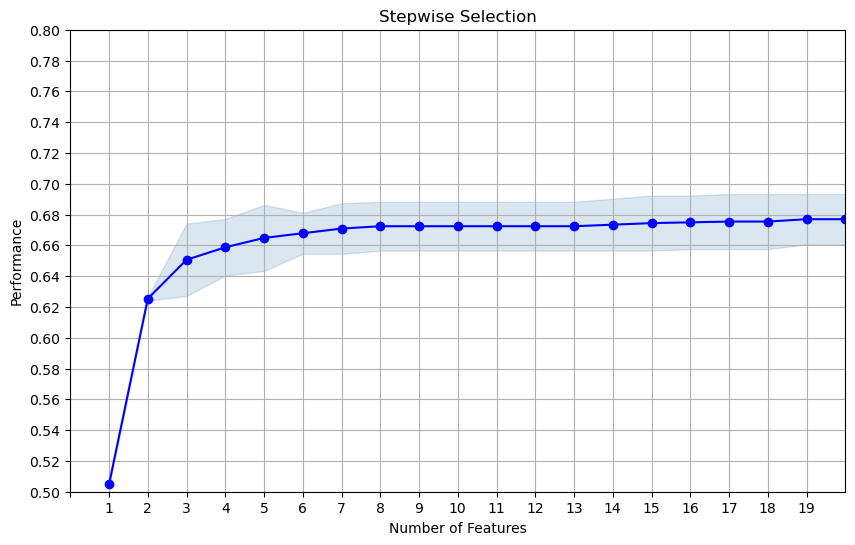

In [65]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(10, 6))
plt.xticks(np.arange(0, num_out_of_wrapper, step=1))
plt.yticks(np.arange(0,1,step=.02))
plt.ylim([.5,.8])
plt.xlim(0,num_out_of_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('performance_nvars.png')
plt.show()

In [66]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [67]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))[0]
# You might also need this following line. It converts a list to a string
#         ordered_vars_FS.loc[i+1,'variable name'] = ordered_vars_FS.loc[i+1,'variable name'][0]

In [68]:
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(7,)","[0.5030364372469636, 0.5065856129685917]",0.504811,"(Cardnum_unique_count_for_card_state_1,)",0.007635,0.001775,0.001775,1.0,Cardnum_unique_count_for_card_state_1
2,"(0, 7)","[0.6265182186234818, 0.624113475177305]",0.625316,"(Cardnum_total_1, Cardnum_unique_count_for_car...",0.005173,0.001202,0.001202,2.0,Cardnum_total_1
3,"(0, 7, 82)","[0.6740890688259109, 0.6271529888551165]",0.650621,"(Cardnum_total_1, Cardnum_unique_count_for_car...",0.100975,0.023468,0.023468,3.0,Card_dow_count_0_by_60_sq
4,"(0, 7, 38, 82)","[0.6771255060728745, 0.6403242147923]",0.658725,"(Cardnum_total_1, Cardnum_unique_count_for_car...",0.079172,0.018401,0.018401,4.0,Cardnum_max_3
5,"(0, 7, 38, 82, 94)","[0.6862348178137652, 0.6433637284701115]",0.664799,"(Cardnum_total_1, Cardnum_unique_count_for_car...",0.09223,0.021436,0.021436,5.0,card_zip_total_amount_1_by_60
6,"(0, 7, 20, 38, 82, 94)","[0.6811740890688259, 0.6545086119554204]",0.667841,"(Cardnum_total_1, Cardnum_unique_count_for_car...",0.057366,0.013333,0.013333,6.0,Card_dow_vdratio_0by14
7,"(0, 7, 20, 38, 77, 82, 94)","[0.687246963562753, 0.6545086119554204]",0.670878,"(Cardnum_total_1, Cardnum_unique_count_for_car...",0.070431,0.016369,0.016369,7.0,Card_dow_total_60
8,"(0, 7, 20, 28, 38, 77, 82, 94)","[0.6882591093117408, 0.6565349544072948]",0.672397,"(Cardnum_total_1, Cardnum_unique_count_for_car...",0.068249,0.015862,0.015862,8.0,Cardnum_actual/toal_0
9,"(0, 7, 18, 20, 28, 38, 77, 82, 94)","[0.6882591093117408, 0.6565349544072948]",0.672397,"(Cardnum_total_1, Cardnum_unique_count_for_car...",0.068249,0.015862,0.015862,9.0,Cardnum_max_1
10,"(0, 7, 18, 20, 23, 28, 38, 77, 82, 94)","[0.6882591093117408, 0.6565349544072948]",0.672397,"(Cardnum_total_1, Cardnum_unique_count_for_car...",0.068249,0.015862,0.015862,10.0,Cardnum_variability_max_1


In [69]:
ordered_vars_FS.to_csv('Wrapper_selection_info.csv', index=False)

In [70]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)
vars_keep

1     Cardnum_unique_count_for_card_state_1
2                           Cardnum_total_1
3                 Card_dow_count_0_by_60_sq
4                             Cardnum_max_3
5             card_zip_total_amount_1_by_60
6                    Card_dow_vdratio_0by14
7                         Card_dow_total_60
8                     Cardnum_actual/toal_0
9                             Cardnum_max_1
10                Cardnum_variability_max_1
11                    Card_dow_vdratio_0by7
12                     Cardnum_vdratio_1by7
13      Cardnum_unique_count_for_card_zip_7
14                         Cardnum_count_14
15                    Cardnum_vdratio_0by30
16                Cardnum_variability_max_0
17                        Card_dow_total_30
18      Cardnum_unique_count_for_Merchnum_7
19                    Cardnum_actual/toal_1
20    Cardnum_unique_count_for_card_state_7
Name: variable name, dtype: object

In [71]:
filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score

,filter score
variable,
Fraud,1.000000
Cardnum_total_1,0.591114
Cardnum_total_1,0.591114
Cardnum_count_1,0.576927
Cardnum_count_1,0.576927
...,...
merch_zip_unique_count_for_merch_state_3,0.000000
merch_zip_unique_count_for_merch_state_1,0.000000
Merchant_dominance_score,0.000000


In [72]:
vars_keep_sorted = pd.DataFrame(vars_keep_list)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()

""
variable
Cardnum_unique_count_for_card_state_1
Cardnum_total_1
Card_dow_count_0_by_60_sq
Cardnum_max_3
card_zip_total_amount_1_by_60


In [73]:
vars_keep_sorted = pd.concat([vars_keep_sorted,filter_score],axis=1,join='inner')

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [74]:
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_keep_sorted.to_csv('vars_keep_sorted.csv',index=False)
vars_keep_sorted

,wrapper order,variable
0,1,Cardnum_unique_count_for_card_state_1
1,2,Cardnum_total_1
2,3,Card_dow_count_0_by_60_sq
3,4,Cardnum_max_3
4,5,card_zip_total_amount_1_by_60
5,6,Card_dow_vdratio_0by14
6,7,Card_dow_total_60
7,8,Cardnum_actual/toal_0
8,9,Cardnum_max_1
9,10,Cardnum_variability_max_1


In [75]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['Cardnum_unique_count_for_card_state_1',
 'Cardnum_total_1',
 'Card_dow_count_0_by_60_sq',
 'Cardnum_max_3',
 'card_zip_total_amount_1_by_60',
 'Card_dow_vdratio_0by14',
 'Card_dow_total_60',
 'Cardnum_actual/toal_0',
 'Cardnum_max_1',
 'Cardnum_variability_max_1',
 'Card_dow_vdratio_0by7',
 'Cardnum_vdratio_1by7',
 'Cardnum_unique_count_for_card_zip_7',
 'Cardnum_count_14',
 'Cardnum_vdratio_0by30',
 'Cardnum_variability_max_0',
 'Card_dow_total_30',
 'Cardnum_unique_count_for_Merchnum_7',
 'Cardnum_actual/toal_1',
 'Cardnum_unique_count_for_card_state_7',
 'Recnum',
 'Fraud']

In [76]:
filter_score

,filter score
variable,
Fraud,1.000000
Cardnum_total_1,0.591114
Cardnum_total_1,0.591114
Cardnum_count_1,0.576927
Cardnum_count_1,0.576927
...,...
merch_zip_unique_count_for_merch_state_3,0.000000
merch_zip_unique_count_for_merch_state_1,0.000000
Merchant_dominance_score,0.000000


In [77]:
%%time
df = pd.read_csv(file_name)
df.shape

CPU times: user 16.2 s, sys: 5.3 s, total: 21.5 s
Wall time: 22.4 s


(98037, 2651)

In [78]:
df_keep = df.filter(vars_keep_list, axis=1)
print(df_keep.shape)

(98037, 22)


In [79]:
df_keep.to_csv('vars_final.csv',index=False)

In [80]:
print("duration: ", dt.datetime.now() - start_time)

duration:  0:10:05.156699


In [81]:
%pwd

'/home/jovyan/Documents/PortWebsit '

In [91]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import random

# === Parameters ===
file_name = 'candidate_variables.csv'
index_name = 'Recnum'
y_name = 'Fraud'
good_label = 0
bad_label = 1
balance = 2
num_to_sample = 1000       # random variable sample size
num_final_vars = 20       # top N after filtering

# Step 1: Read headers only to get variable names
all_cols = pd.read_csv(file_name, nrows=1).columns.tolist()
all_vars = [col for col in all_cols if col not in [index_name, y_name]]

# Step 2: Randomly sample variable subset
random.seed(42)  # change for multiple experiments
vars_sampled = random.sample(all_vars, num_to_sample)
vars_sampled += [index_name, y_name]  # always include ID + target

# Step 3: Load only the sampled columns
df = pd.read_csv(file_name, usecols=vars_sampled)
df = df.set_index(index_name)
df = df[(df.index >= 3515) & (df.index <= 85730)]
df['RANDOM'] = np.random.rand(len(df))

# Step 4: Split into goods and bads
goods = df[df[y_name] == good_label]
bads = df[df[y_name] == bad_label]

if balance != 0:
    num_goods_desired = int(min(len(goods), len(bads) * balance))
    goods = goods.sample(n=num_goods_desired, random_state=1)

df_sampled = pd.concat([goods, bads]).sort_index()

# Step 5: Run KS filter
ks_scores = []
for col in df_sampled.columns:
    if col != y_name:
        score = sps.ks_2samp(goods[col], bads[col])[0]
        ks_scores.append((col, score))

ks_df = pd.DataFrame(ks_scores, columns=['variable', 'ks_score'])
ks_df.sort_values(by='ks_score', ascending=False, inplace=True)

# Step 6: Select top variables
top_vars = ks_df['variable'].head(num_final_vars).tolist()
X = df_sampled[top_vars]
Y = df_sampled[y_name]

print("✅ Selected top variables:")
print(ks_df.head(num_final_vars))


✅ Selected top variables:
                                    variable  ks_score
7                            Cardnum_total_1  0.594684
13                           Cardnum_total_3  0.578734
10                           Cardnum_count_3  0.576203
16                           Cardnum_total_7  0.525570
799      Cardnum_unique_count_for_card_zip_1  0.520253
802    Cardnum_unique_count_for_card_state_1  0.517468
634                   Card_dow_vdratio_0by30  0.514430
794      Cardnum_unique_count_for_Merchnum_3  0.508101
665                Cardnum_variability_max_0  0.505063
611                    Cardnum_vdratio_1by14  0.501519
667                Cardnum_variability_max_1  0.500000
852  Card_dow_unique_count_for_merch_state_1  0.495949
9                      Cardnum_actual/toal_1  0.484810
610                     Cardnum_vdratio_1by7  0.483038
5                       Cardnum_actual/max_0  0.475696
235                        Card_dow_total_14  0.475696
795      Cardnum_unique_count_for_Merch

Random forest


⏱️ Wrapper runtime (RF): 152.71 seconds


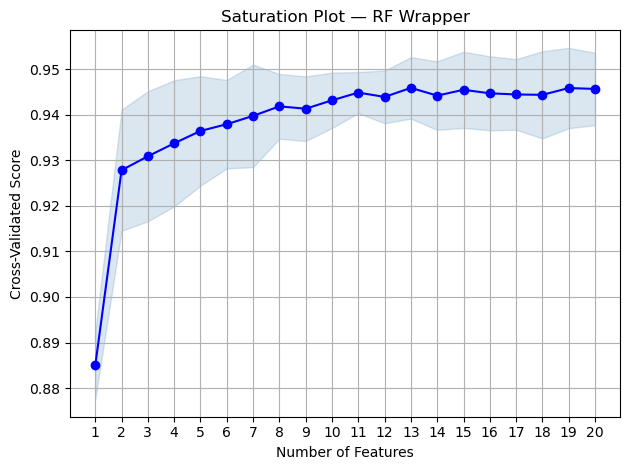

✅ Top 20 Selected by RandomForest:
 ['Cardnum_total_1', 'Cardnum_total_3', 'Cardnum_count_3', 'Cardnum_total_7', 'Cardnum_unique_count_for_card_state_1', 'Cardnum_unique_count_for_Merchnum_3', 'Cardnum_variability_max_0', 'Card_dow_unique_count_for_merch_state_1', 'Card_dow_day_since', 'Cardnum_day_since', 'Card_dow_max_30', 'Cardnum_vdratio_0by7', 'Cardnum_unique_count_for_Merchnum_30', 'Card_dow_count_0_by_30', 'Cardnum_total_amount_1_by_14', 'card_state_count_1_by_60', 'card_zip_count_1_by_60', 'Cardnum_unique_count_for_card_state_60', 'card_state_count_1_by_30', 'Cardnum_unique_count_for_card_zip_60']


In [92]:
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
import time

# Prepare your top N from KS filter
top_60_vars = ks_df['variable'].head(60).tolist()
X = df_sampled[top_60_vars]
Y = df_sampled[y_name]

# Wrapper with Random Forest
start = time.time()

sfs = SFS(
    estimator=RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    k_features=20,
    forward=True,
    floating=False,
    scoring='roc_auc',  # or custom FDR scorer
    cv=3,
    n_jobs=-1
)

sfs = sfs.fit(X.values, Y.values)

end = time.time()
print("⏱️ Wrapper runtime (RF): {:.2f} seconds".format(end - start))

# Plot
fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Saturation Plot — RF Wrapper')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validated Score')
plt.grid(True)
plt.tight_layout()
plt.show()

# Selected features
selected_vars_rf = [top_60_vars[i] for i in sfs.k_feature_idx_]
print("✅ Top 20 Selected by RandomForest:\n", selected_vars_rf)


Logistic regression

⏱️ Wrapper runtime (LogReg): 20.56 seconds


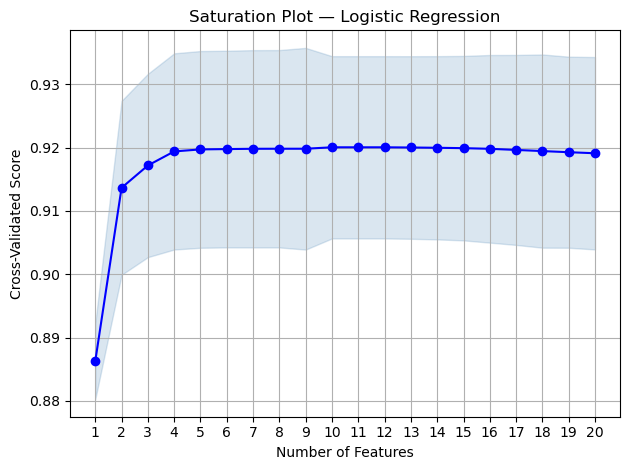

✅ Top 20 Selected by Logistic Regression:
 ['Cardnum_total_1', 'Cardnum_total_3', 'Card_dow_vdratio_0by30', 'Cardnum_vdratio_1by14', 'Cardnum_variability_max_1', 'Card_dow_unique_count_for_merch_state_1', 'Cardnum_count_1_by_30', 'Cardnum_count_1_by_14_sq', 'Card_dow_count_0_by_60', 'Cardnum_unique_count_for_card_zip_30', 'Cardnum_variability_avg_0', 'Card_dow_count_0_by_30', 'card_state_count_1_by_60', 'Cardnum_count_0_by_60_sq', 'Cardnum_count_0_by_60', 'card_zip_count_1_by_60', 'Card_dow_total_amount_0_by_60', 'Cardnum_count_1_by_7_sq', 'Card_Merchnum_State_count_1_by_60_sq', 'Cardnum_variability_avg_1']


In [94]:
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
import time

# Use your filtered top variables
top_60_vars = ks_df['variable'].head(60).tolist()
X = df_sampled[top_60_vars]
Y = df_sampled[y_name]

# Run wrapper with Logistic Regression
start = time.time()

sfs = SFS(
    estimator=LogisticRegression(max_iter=500, solver='lbfgs'),
    k_features=20,
    forward=True,
    floating=False,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)

sfs = sfs.fit(X.values, Y.values)

end = time.time()
print("⏱️ Wrapper runtime (LogReg): {:.2f} seconds".format(end - start))

# Plot saturation
fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Saturation Plot — Logistic Regression')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validated Score')
plt.grid(True)
plt.tight_layout()
plt.show()

# Save (option

# Top variables
selected_vars_log = [top_60_vars[i] for i in sfs.k_feature_idx_]
print("✅ Top 20 Selected by Logistic Regression:\n", selected_vars_log)


⏱️ Logistic Regression wrapper time: 13.03 seconds


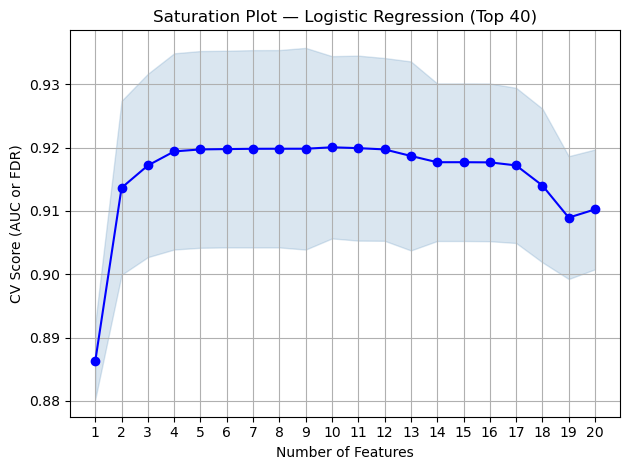

✅ Top 20 Selected by Logistic Regression:
 ['Cardnum_total_1', 'Cardnum_total_3', 'Cardnum_count_3', 'Card_dow_vdratio_0by30', 'Cardnum_vdratio_1by14', 'Cardnum_variability_max_1', 'Card_dow_unique_count_for_merch_state_1', 'Cardnum_vdratio_1by7', 'Cardnum_actual/max_0', 'Cardnum_unique_count_for_Merchnum_7', 'Cardnum_day_since', 'Cardnum_count_1_by_30', 'Card_dow_variability_max_7', 'Cardnum_count_1_by_14_sq', 'Card_dow_max_30', 'Card_dow_count_0_by_60', 'Cardnum_vdratio_0by7', 'Cardnum_unique_count_for_card_zip_30', 'Cardnum_variability_avg_0', 'Card_dow_count_0_by_30']


In [95]:
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
import time

# Use top 40 from KS filter
top_vars_logreg = ks_df['variable'].head(40).tolist()
X = df_sampled[top_vars_logreg]
Y = df_sampled[y_name]

# Fastest wrapper config
start = time.time()

sfs = SFS(
    estimator=LogisticRegression(max_iter=300),
    k_features=20,
    forward=True,
    floating=False,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)

sfs = sfs.fit(X.values, Y.values)

end = time.time()
print("⏱️ Logistic Regression wrapper time: {:.2f} seconds".format(end - start))

# Plot
fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Saturation Plot — Logistic Regression (Top 40)')
plt.xlabel('Number of Features')
plt.ylabel('CV Score (AUC or FDR)')
plt.grid(True)
plt.tight_layout()
plt.show()



# Output selected variables
selected_vars_logreg = [top_vars_logreg[i] for i in sfs.k_feature_idx_]
print("✅ Top 20 Selected by Logistic Regression:\n", selected_vars_logreg)


In [96]:
import pandas as pd
import numpy as np
import scipy.stats as sps

# Parameters
y_name = 'Fraud'
good_label = 0
bad_label = 1
balance = 2
top_n_per_group = 5  # or 3, 10, depending on how many groups

# 1. Define entity groups
group_prefixes = {
    'Card-Level': ['Cardnum_', 'card_'],
    'Merchant-Level': ['Merchnum_', 'merch_'],
    'ZIP-Level': ['zip_', 'card_zip_', 'merch_zip_'],
    'State-Level': ['state_', 'card_state_', 'merch_state_'],
    'DOW-Time': ['dow_', '_day_since', '_vdratio_', 'variability_']
}

# 2. Split goods and bads
goods = df_sampled[df_sampled[y_name] == good_label]
bads = df_sampled[df_sampled[y_name] == bad_label]

# Optional balancing
if balance != 0:
    num_goods_desired = int(min(len(goods), len(bads) * balance))
    goods = goods.sample(n=num_goods_desired, random_state=1)

# 3. Function to run KS on a subset of columns
def ks_filter(df_g, df_b, columns, top_n):
    scores = []
    for col in columns:
        try:
            score = sps.ks_2samp(df_g[col], df_b[col])[0]
            scores.append((col, score))
        except:
            continue
    ks_df = pd.DataFrame(scores, columns=['variable', 'ks_score'])
    ks_df.sort_values(by='ks_score', ascending=False, inplace=True)
    return ks_df.head(top_n)

# 4. Apply group-wise
final_vars = []

for group, prefixes in group_prefixes.items():
    group_vars = [col for col in df_sampled.columns if any(p in col for p in prefixes)]
    print(f"🔍 Group: {group} — {len(group_vars)} candidates")
    top_group_vars = ks_filter(goods, bads, group_vars, top_n_per_group)
    print(top_group_vars)
    final_vars.extend(top_group_vars['variable'].tolist())

# 5. Output final list
print(f"\n✅ Final selected variables from grouped logic ({len(final_vars)} total):")
print(final_vars)


🔍 Group: Card-Level — 196 candidates
                                variable  ks_score
4                        Cardnum_total_1  0.594684
10                       Cardnum_total_3  0.578734
7                        Cardnum_count_3  0.576203
13                       Cardnum_total_7  0.525570
165  Cardnum_unique_count_for_card_zip_1  0.520253
🔍 Group: Merchant-Level — 540 candidates
                                     variable  ks_score
400       Cardnum_unique_count_for_Merchnum_3  0.508101
437   Card_dow_unique_count_for_merch_state_1  0.495949
401       Cardnum_unique_count_for_Merchnum_7  0.470633
402      Cardnum_unique_count_for_Merchnum_14  0.440253
438  Card_dow_unique_count_for_merch_state_30  0.386076
🔍 Group: ZIP-Level — 110 candidates
                                variable  ks_score
72   Cardnum_unique_count_for_card_zip_1  0.520253
73  Cardnum_unique_count_for_card_zip_30  0.373165
52                card_zip_count_1_by_60  0.330127
74  Cardnum_unique_count_for_card_zip_60

In [97]:
from xgboost import XGBClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
import time

# Step 1: Use top 60 variables from KS
top_vars_xgb = ks_df['variable'].head(60).tolist()
X = df_sampled[top_vars_xgb]
Y = df_sampled[y_name]

# Step 2: Wrap with XGBoost
start = time.time()

sfs = SFS(
    estimator=XGBClassifier(n_estimators=50, max_depth=3, use_label_encoder=False, eval_metric='logloss'),
    k_features=20,
    forward=True,
    floating=False,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)

sfs = sfs.fit(X.values, Y.values)

end = time.time()
print("⏱️ Wrapper runtime (XGBoost): {:.2f} seconds".format(end - start))

# Step 3: Plot saturation
fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Saturation Plot — XGBoost Wrapper')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validated Score')
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional save
fig.savefig("saturation_xgb_expX.png", dpi=300)

# Step 4: Extract selected variables
selected_vars_xgb = [top_vars_xgb[i] for i in sfs.k_feature_idx_]
print("✅ Top 20 Selected by XGBoost:\n", selected_vars_xgb)


AttributeError: 'super' object has no attribute '__sklearn_tags__'

⏱️ Runtime (HistGB): 56.70 seconds


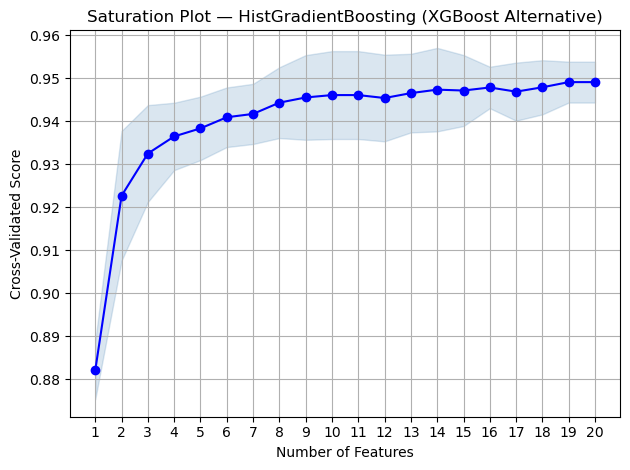

✅ Selected Variables:
 ['Cardnum_total_1', 'Cardnum_total_3', 'Cardnum_unique_count_for_card_state_1', 'Cardnum_variability_max_0', 'Card_dow_unique_count_for_merch_state_1', 'Cardnum_unique_count_for_Merchnum_7', 'Card_dow_max_7', 'Cardnum_actual/max_1', 'Cardnum_unique_count_for_Merchnum_14', 'Card_dow_variability_max_7', 'Card_dow_unique_count_for_Card_Merchdesc_14', 'Card_dow_unique_count_for_merch_state_30', 'Card_dow_max_30', 'Card_dow_variability_max_14', 'Cardnum_count_0_by_60_sq', 'Cardnum_count_0_by_60', 'Card_dow_total_amount_0_by_60', 'Cardnum_actual/toal_7', 'Card_Merchnum_State_count_1_by_60_sq', 'Card_Merchnum_State_count_1_by_60']


In [100]:
from sklearn.ensemble import HistGradientBoostingClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
import time

# Use top 60 from your KS filter
top_vars = ks_df['variable'].head(60).tolist()
X = df_sampled[top_vars]
Y = df_sampled['Fraud']

# Start timing
start = time.time()

# Wrapper with HistGradientBoostingClassifier
sfs = SFS(
    estimator=HistGradientBoostingClassifier(max_iter=100, max_leaf_nodes=20),
    k_features=20,
    forward=True,
    floating=False,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)

sfs = sfs.fit(X.values, Y.values)
end = time.time()
print("⏱️ Runtime (HistGB): {:.2f} seconds".format(end - start))

# Plot saturation
fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Saturation Plot — HistGradientBoosting (XGBoost Alternative)')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validated Score')
plt.grid(True)
plt.tight_layout()
plt.show()



# Final selected vars
selected_vars_histgb = [top_vars[i] for i in sfs.k_feature_idx_]
print("✅ Selected Variables:\n", selected_vars_histgb)


⏱️ Backward wrapper runtime: 3717.02 seconds


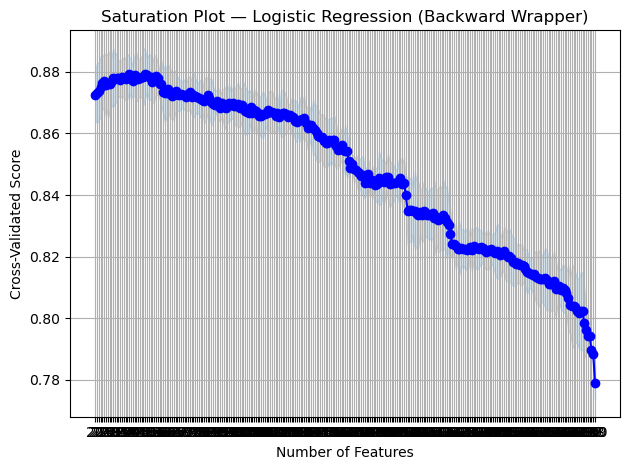

✅ Selected Variables:
 ['Cardnum_total_1', 'Cardnum_total_3', 'Cardnum_variability_max_0', 'Cardnum_variability_max_1', 'Card_dow_day_since', 'Cardnum_count_30', 'Card_Merchdesc_Zip_total_60', 'Merchnum_total_1', 'card_state_total_30', 'card_zip_total_0', 'Card_Merchdesc_Zip_max_14', 'Merchnum_desc_State_max_3', 'Merchdesc_Zip_avg_1', 'Merchnum_dow_total_14', 'Card_Merchdesc_Zip_max_60', 'Card_Merchdesc_med_7', 'Merchnum_avg_1', 'card_state_total_60', 'card_merch_med_60', 'Merchnum_desc_Zip_avg_30']


In [102]:
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
import time

# === Step 1: Use top 30 variables from KS filter ===
top_vars_backward = ks_df['variable'].head(300).tolist()
X = df_sampled[top_vars_backward]
Y = df_sampled['Fraud']  # or Y = df_sampled[y_name]

# === Step 2: Backward Wrapper Setup ===
start = time.time()

sfs = SFS(
    estimator=LogisticRegression(max_iter=300),
    k_features=20,  # select 20 out of 30
    forward=False,  # backward elimination
    floating=False,
    scoring='roc_auc',
    cv=2,
    n_jobs=-1
)

sfs = sfs.fit(X.values, Y.values)

end = time.time()
print("⏱️ Backward wrapper runtime: {:.2f} seconds".format(end - start))

# === Step 3: Plot Saturation ===
fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Saturation Plot — Logistic Regression (Backward Wrapper)')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validated Score')
plt.grid(True)
plt.tight_layout()
plt.show()


# Final feature list
selected_vars_backward = [top_vars_backward[i] for i in sfs.k_feature_idx_]
print("✅ Selected Variables:\n", selected_vars_backward)
